In [ ]:
!pip install -q transformers accelerate bitsandbytes gdown safetensors

In [2]:
import gdown, zipfile, os, shutil

file_id = "1_-VzTv2-3XwzMy_ju6gUo3j8-XOnGChK"
url = f"https://drive.google.com/uc?id={file_id}"
zip_path = "visdia.zip"

gdown.download(url, zip_path, quiet=False)

if zipfile.is_zipfile(zip_path):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall("visdia_data")
else:
    shutil.move(zip_path, "visdia_data/QA_info.json")


Downloading...
From (original): https://drive.google.com/uc?id=1_-VzTv2-3XwzMy_ju6gUo3j8-XOnGChK
From (redirected): https://drive.google.com/uc?id=1_-VzTv2-3XwzMy_ju6gUo3j8-XOnGChK&confirm=t&uuid=06acd046-cb83-4cd7-9e2a-2b87238b3d9a
To: /kaggle/working/visdia.zip
100%|██████████| 3.48G/3.48G [00:13<00:00, 252MB/s]


In [3]:
import json, os

json_path = "visdia_data/QA_info.json"
img_root = "visdia_data/images"

with open(json_path) as f:
    meta = json.load(f)

print("samples:", len(meta))
print("example keys:", list(meta.keys())[:5])


samples: 5000
example keys: ['2353884', '2320168', '2410049', '2375361', '2410046']


In [ ]:
from transformers import LlavaForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "llava-hf/llava-1.5-7b-hf"

bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb,
    device_map="auto",
    trust_remote_code=True
)

processor = AutoProcessor.from_pretrained(
    model_id,
    trust_remote_code=True
)


Turns: 5
[{'question': 'Does the shore have the color green?', 'question_type': 'verifyAttr', 'object_chain': [['[st]', '[st]', '1541074']], 'answer_triplets': ['1541074', '<attribute>', 'green'], 'answer': 'no', 'answer_type': 'YN', 'image_id': '1031', 'round': 0, 'hallucination_type': None, 'prompt': '<obj>: shore; <answer triplet>: shore, <attribute>, green; <answer>: no; ', 'prompt_trimmed': '<obj>: shore; <query>: <attribute>; <answer>: no; ', 'last_round_input': None}, {'question': 'Is the lake the color it?', 'question_type': 'verifyTargetAttr', 'object_chain': [['[st]', '[st]', '1541073']], 'answer_triplets': ['1541073', '<attribute>', 'green'], 'answer': 'yes', 'answer_type': 'YN', 'image_id': '1031', 'round': 1, 'hallucination_type': None, 'prompt': '<obj>: lake; <answer triplet>: lake, <attribute>, green; <answer>: yes; ', 'prompt_trimmed': '<obj>: lake; <query>: <attribute>; <answer>: yes; ', 'last_round_input': 'green'}]


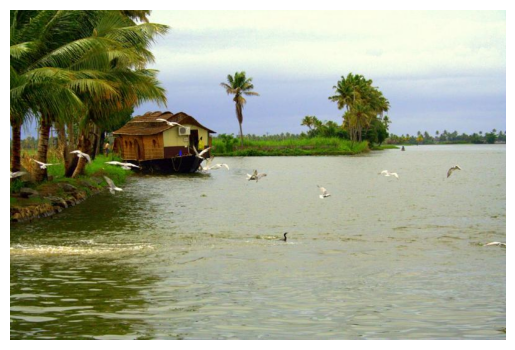

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

sample_id = sorted(os.listdir(img_root))[1]
path = os.path.join(img_root, sample_id)

img_org = Image.open(os.path.join(path, "org.png")).convert("RGB")
dialog = meta[sample_id]["dialogue"]

plt.imshow(img_org); plt.axis("off")
print("Turns:", len(dialog))
print(dialog[:2])



Sample: 1016


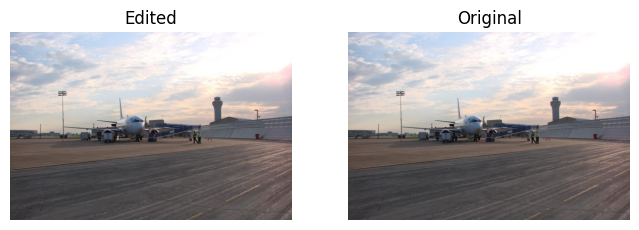

Q: Where are the pears in relation to the tall pole?
A: pears
Q: Is it tall?
A: yes
Q: Is the green vest to the left of the trash can?
A: unanswerable
Q: What is the color of it?
A: unanswerable
Q: What is the name of the object that consists of wheels and is related to the airplane?
A: wheels
Q: What is the name of the object that consists of wheels and is related to the airplane?
GT: wheels
Pred: cart

Sample: 1031


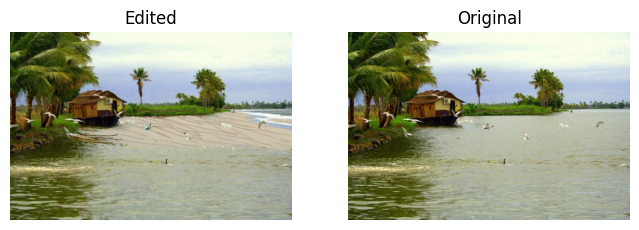

Q: Does the shore have the color green?
A: no
Q: Is the lake the color it?
A: yes
Q: What is the attribute of the stone?
A: unanswerable
Q: Is the sky the same attribute as the one mentioned in the last round?
A: unanswerable
Q: What is the color of the shore?
A: green
Q: What is the color of the shore?
GT: green
Pred: green

Sample: 1057


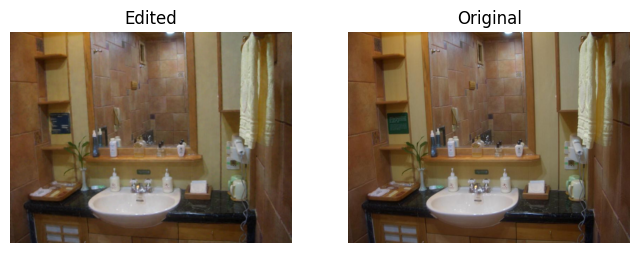

Q: What is the color of the sign?
A: navy
Q: Does it have the navy attribute?
A: yes
Q: What is the material of the fork?
A: unanswerable
Q: Does the bowl have the same attribute as it?
A: unanswerable
Q: What is the color of the sign?
A: green
Q: What is the color of the sign?
GT: green
Pred: green


In [14]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image

def get_imgs(folder):
    files = os.listdir(folder)
    org = os.path.join(folder, "org.png")
    mods = [os.path.join(folder, f) for f in files if f.endswith(".png") and f != "org.png"]
    return org, (mods[0] if mods else None)

def build_prompt(dialog, idx):
    prompt = "USER: <image>\n"
    for t in dialog[:idx]:
        prompt += f"{t['question']} ASSISTANT: {t['answer']} USER: "
    q, gt = dialog[idx]["question"], dialog[idx]["answer"]
    prompt += f"{q} ASSISTANT:"
    return prompt, q, gt

for sid in sorted(os.listdir(img_root))[:3]:
    print(f"\nSample: {sid}")
    folder = os.path.join(img_root, sid)
    org_path, mod_path = get_imgs(folder)

    img_org = Image.open(org_path).convert("RGB")
    img_mod = Image.open(mod_path).convert("RGB") if mod_path else img_org
    dialog = meta[sid]["dialogue"]

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1); plt.imshow(img_mod); plt.title("Edited"); plt.axis("off")
    plt.subplot(1, 2, 2); plt.imshow(img_org); plt.title("Original"); plt.axis("off")
    plt.show()

    for t in dialog:
        print(f"Q: {t['question']}\nA: {t['answer']}")

    prompt_h, q_h, gt_h = build_prompt(dialog, 4)
    inputs_h = processor(text=prompt_h, images=img_mod, return_tensors="pt")
    inputs_h = {k: v.to(device) for k, v in inputs_h.items()}
    with torch.no_grad():
        model.generate(**inputs_h, max_new_tokens=1)

    prompt_t5, q_t5, gt_t5 = build_prompt(dialog, 4)
    inputs_t5 = processor(text=prompt_t5, images=img_org, return_tensors="pt")
    inputs_t5 = {k: v.to(device) for k, v in inputs_t5.items()}
    with torch.no_grad():
        out = model.generate(**inputs_t5, max_new_tokens=80, do_sample=False)

    text = processor.tokenizer.decode(out[0], skip_special_tokens=True)
    pred = text.split("ASSISTANT:")[-1].strip()

    print(f"Q: {q_t5}\nGT: {gt_t5}\nPred: {pred}")
